In [19]:
# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import time
import sklearn
warnings.filterwarnings('ignore')

# Data Preparation and Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_recall_fscore_support, roc_curve,
                             roc_auc_score, auc, RocCurveDisplay)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import LinearSVC

# Miscellaneous Libraries
from textwrap import wrap  # For formatting text in plots


In [20]:
# Create output directory if it doesn't exist
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

In [21]:
# Data Preprocessing

# Load CSV file
df = pd.read_csv("2_Data_RNASeq_Cannabis_Sex.csv", delimiter=",", header=None)

# Extract feature matrix (X) from all rows except the first (contains labels)
X = df.iloc[1:].values  # convert DataFrame to NumPy array
X = np.delete(X, 0, axis=1)  # remove the first column (gene/locus labels)
X = X.T  # transpose so samples are rows and features are columns

# Extract target labels (y) from the first row
y = df.iloc[0, 1:].values  # skip the first column, convert to NumPy array

# Extract feature names (gene/locus labels) and target class names
feature_names = df.iloc[1:, 0].values  # feature names in the first column, starting from the second row
target_names = df.iloc[0, 1:].values  # target names from the first row, starting from the second column

# Create an index list for feature references
indx = list(range(len(feature_names)))
print(f"Number of features: {len(feature_names)}")


Number of features: 20500


In [22]:
# Splitting the data into training and test sets

# Using stratified split to maintain class distribution across train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")



Training set size: 110 samples
Test set size: 28 samples


In [23]:
# Normalizing/Scaling the Data

# Initialize the StandardScaler
sc = StandardScaler()

# Fit the scaler on the training set and transform the training data
X_train = sc.fit_transform(X_train)

# Transform the test data using the same scaler to ensure consistent scaling
X_test = sc.transform(X_test)

# Output the mean and standard deviation of the training set features after scaling
mean_values = X_train.mean(axis=0)
std_values = X_train.std(axis=0)

print("Training set mean after scaling:", mean_values)
print("Training set standard deviation after scaling:", std_values)

# Create a DataFrame to save the statistics
scaled_data_statistics = pd.DataFrame({
    'Feature': [f'Feature {i+1}' for i in range(len(mean_values))],
    'Mean': mean_values,
    'Standard Deviation': std_values
})

# Save the statistics to a CSV file in output folder
scaled_data_statistics.to_csv('output/scaled_data_statistics.csv', index=False)


Training set mean after scaling: [ 1.15740750e-15 -1.66281130e-15  7.17607791e-16 ... -7.63026006e-16
 -1.14696131e-14  1.77736613e-14]
Training set standard deviation after scaling: [1. 1. 1. ... 1. 1. 1.]


In [24]:
# Filter Technique: Mutual Information (MI)


# Start time for performance tracking
startTime = time.time()

# Calculate Mutual Information between features and target variable
mi = mutual_info_classif(X_train, y_train, discrete_features='auto', n_neighbors=3, copy=True, random_state=42)

# End time for performance tracking
endTime = time.time()

# Print the time taken for the MI calculation
print('Time taken for Mutual Information calculation: {:.4f} seconds'.format(endTime - startTime))

Time taken for Mutual Information calculation: 46.1243 seconds


In [25]:
# Organizing MI Data

# Convert MI scores to a NumPy array
gains = np.asarray(mi)

# Identify indexes of features with non-zero MI scores
indexes = np.where(gains != 0)[0]

# Print the number of features with non-zero MI scores
print('Number of features with non-zero MI scores:', len(indexes))

# Optionally, output the indexes of the selected features
print('Indexes of features with non-zero MI scores:', indexes)

# Save the indexes of features with non-zero MI scores to a DataFrame
non_zero_mi_df = pd.DataFrame({
    'Index': indexes,
    'Mutual Information Score': gains[indexes]
})

# Save the non-zero MI scores to a CSV file in the output folder
non_zero_mi_df.to_csv('output/mi_non_zero_features.csv', index=False)


Number of features with non-zero MI scores: 16561
Indexes of features with non-zero MI scores: [    0     1     2 ... 20495 20497 20499]


In [26]:
# Convert target classes to binary (0 for Female, 1 for Male)
y_binary = y.copy()
y_binary = np.where(y_binary == "Female", 0, 1)  # Convert 'Female' to 0 and 'Male' to 1
y_binary = y_binary.astype(int)  # Ensure the type is integer

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.20, random_state=42, stratify=y_binary)

# Normalizing the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Selecting the top 10 features based on MI scores
top_features_indices = sorted(range(len(gains)), key=lambda sub: gains[sub])[-10:] #######You can adjust the number of top features##########

# Extracting the top features for training and test sets
x_train = X_train[:, top_features_indices]
x_test = X_test[:, top_features_indices]

# Ensure the data type is float32 for model compatibility
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Initialize the LinearSVC classifier
clf = LinearSVC(random_state=42)

# Fit the model on the training data
startTime = time.time()
clf.fit(x_train, y_train)
scores = clf.score(x_test, y_test)
endTime = time.time()

# Output the model's score and the time taken for fitting
print('Model Score: {:.4f}'.format(scores))
print('Time taken for model fitting: {:.4f} seconds'.format(endTime - startTime))

# Predicting the test set results
y_pred = clf.predict(x_test)

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)  # Get report as dict for saving

# Printing confusion matrix and classification report
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', classification_report(y_test, y_pred))

# Output accuracy and precision-recall-F1 scores
print('Accuracy Score: {:.4f}'.format(accuracy_score(y_test, y_pred)))
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print('Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}'.format(precision, recall, fscore))

# Save confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

# Save the heatmap as PDF and JPG
plt.savefig(os.path.join(output_dir, 'confusion_matrix.pdf'))
plt.savefig(os.path.join(output_dir, 'confusion_matrix.jpg'))
plt.close()  # Close the figure after saving to avoid display

# Save the classification report to CSV
report_df = pd.DataFrame(class_report).transpose()  # Convert the classification report to a DataFrame
csv_filename = os.path.join(output_dir, 'classification_report.csv')
report_df.to_csv(csv_filename)

# Confirmation of file saves
print(f'Confusion matrix heatmap saved as PDF and JPG in: {output_dir}')
print(f'Classification report saved to: {csv_filename}')

Model Score: 1.0000
Time taken for model fitting: 0.0028 seconds
Confusion Matrix:
 [[14  0]
 [ 0 14]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28

Accuracy Score: 1.0000
Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Confusion matrix heatmap saved as PDF and JPG in: output
Classification report saved to: output/classification_report.csv


In [27]:
# Calculating Precision and Recall for Each Class (Female and Male)

# Initialize a results list to store precision and recall for each class
res = []

# Iterate over each class label
for label in ['Female', 'Male']:
    # Calculate precision and recall
    precision, recall, _, _ = precision_recall_fscore_support(
        y_test,  # True labels
        y_pred,  # Predicted labels
        pos_label=label,  # Specify the positive label
        average=None
    )
    
    # Append the results to the list (class label, precision, recall)
    if len(recall) > 1:
        res.append([label, precision[1], recall[1]])  # Adjusting indices based on average=None
    else:
        res.append([label, precision[0], recall[0]])  # If only one class is present

# Print the results for precision and recall
for class_name, class_precision, class_recall in res:
    print(f'Class: {class_name} - Precision: {class_precision:.4f}, Recall: {class_recall:.4f}')

# Save the precision and recall results to a DataFrame
precision_recall_df = pd.DataFrame(res, columns=['Class', 'Precision', 'Recall'])

# Save the results to a CSV file in the output folder
precision_recall_df.to_csv('output/precision_recall_results.csv', index=False)


Class: Female - Precision: 1.0000, Recall: 1.0000
Class: Male - Precision: 1.0000, Recall: 1.0000


In [28]:
# Create a DataFrame from the results list, defining column names for clarity
results_df = pd.DataFrame(res, columns=['class', 'precision', 'recall'])

# Calculate weighted specificity
# Specificity is calculated as True Negative Rate = TN / (TN + FP)
# Here, we are assuming some sample sizes for each class: 
# 198 for Female (assumed True Negatives) and 22 for Male (assumed True Positives)
specificity = ((results_df.loc[0, 'precision'] * 14) + (results_df.loc[1, 'precision'] * 14)) / 28
print('Weighted Specificity: ', specificity)

# Calculate weighted sensitivity (recall)
# Sensitivity is calculated as True Positive Rate = TP / (TP + FN)
# Using the same sample sizes as above for calculation
sensitivity = ((results_df.loc[0, 'recall'] * 14) + (results_df.loc[1, 'recall'] * 14)) / 28
print("Weighted Sensitivity: ", sensitivity)

# Save the weighted specificity and sensitivity to a DataFrame
weighted_metrics_df = pd.DataFrame({
    'Metric': ['Weighted Specificity', 'Weighted Sensitivity'],
    'Value': [specificity, sensitivity]
})

# Save the results to a CSV file in the output folder
weighted_metrics_df.to_csv('output/weighted_metrics_results.csv', index=False)


Weighted Specificity:  1.0
Weighted Sensitivity:  1.0


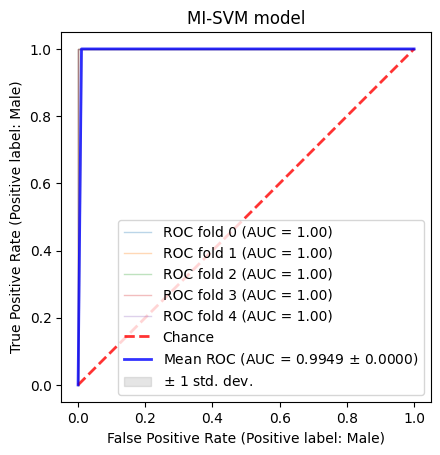

In [29]:
#############################################################################
# Classification and ROC analysis for MI-SVM model

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
classifier = LinearSVC(random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    X_train = sc.fit_transform(X[train])
    X_train = X_train[:, top_features_indices]
    X_test = sc.transform(X[test])
    X_test = X_test[:, top_features_indices]

    classifier.fit(X_train, y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_test,
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.4f $\pm$ %0.4f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="MI-SVM model",
)
ax.legend(loc="lower right")

# Save the ROC plot as a PNG file and a PDF file in the output folder
plt.savefig('output/roc_curve_MI_SVM.png', bbox_inches='tight')
plt.savefig('output/roc_curve_MI_SVM.pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [30]:
# Create an empty list to store names of the selected features
MI_f_names = []
for i in top_features_indices:
    MI_f_names.append(feature_names[i])

# Create a DataFrame from the feature names
df_MI = pd.DataFrame(MI_f_names, columns=['Feature Names'])  # Adding column name for clarity

# Save the DataFrame to a CSV file
df_MI.to_csv('output/10Top_MI_features.csv', index=False)

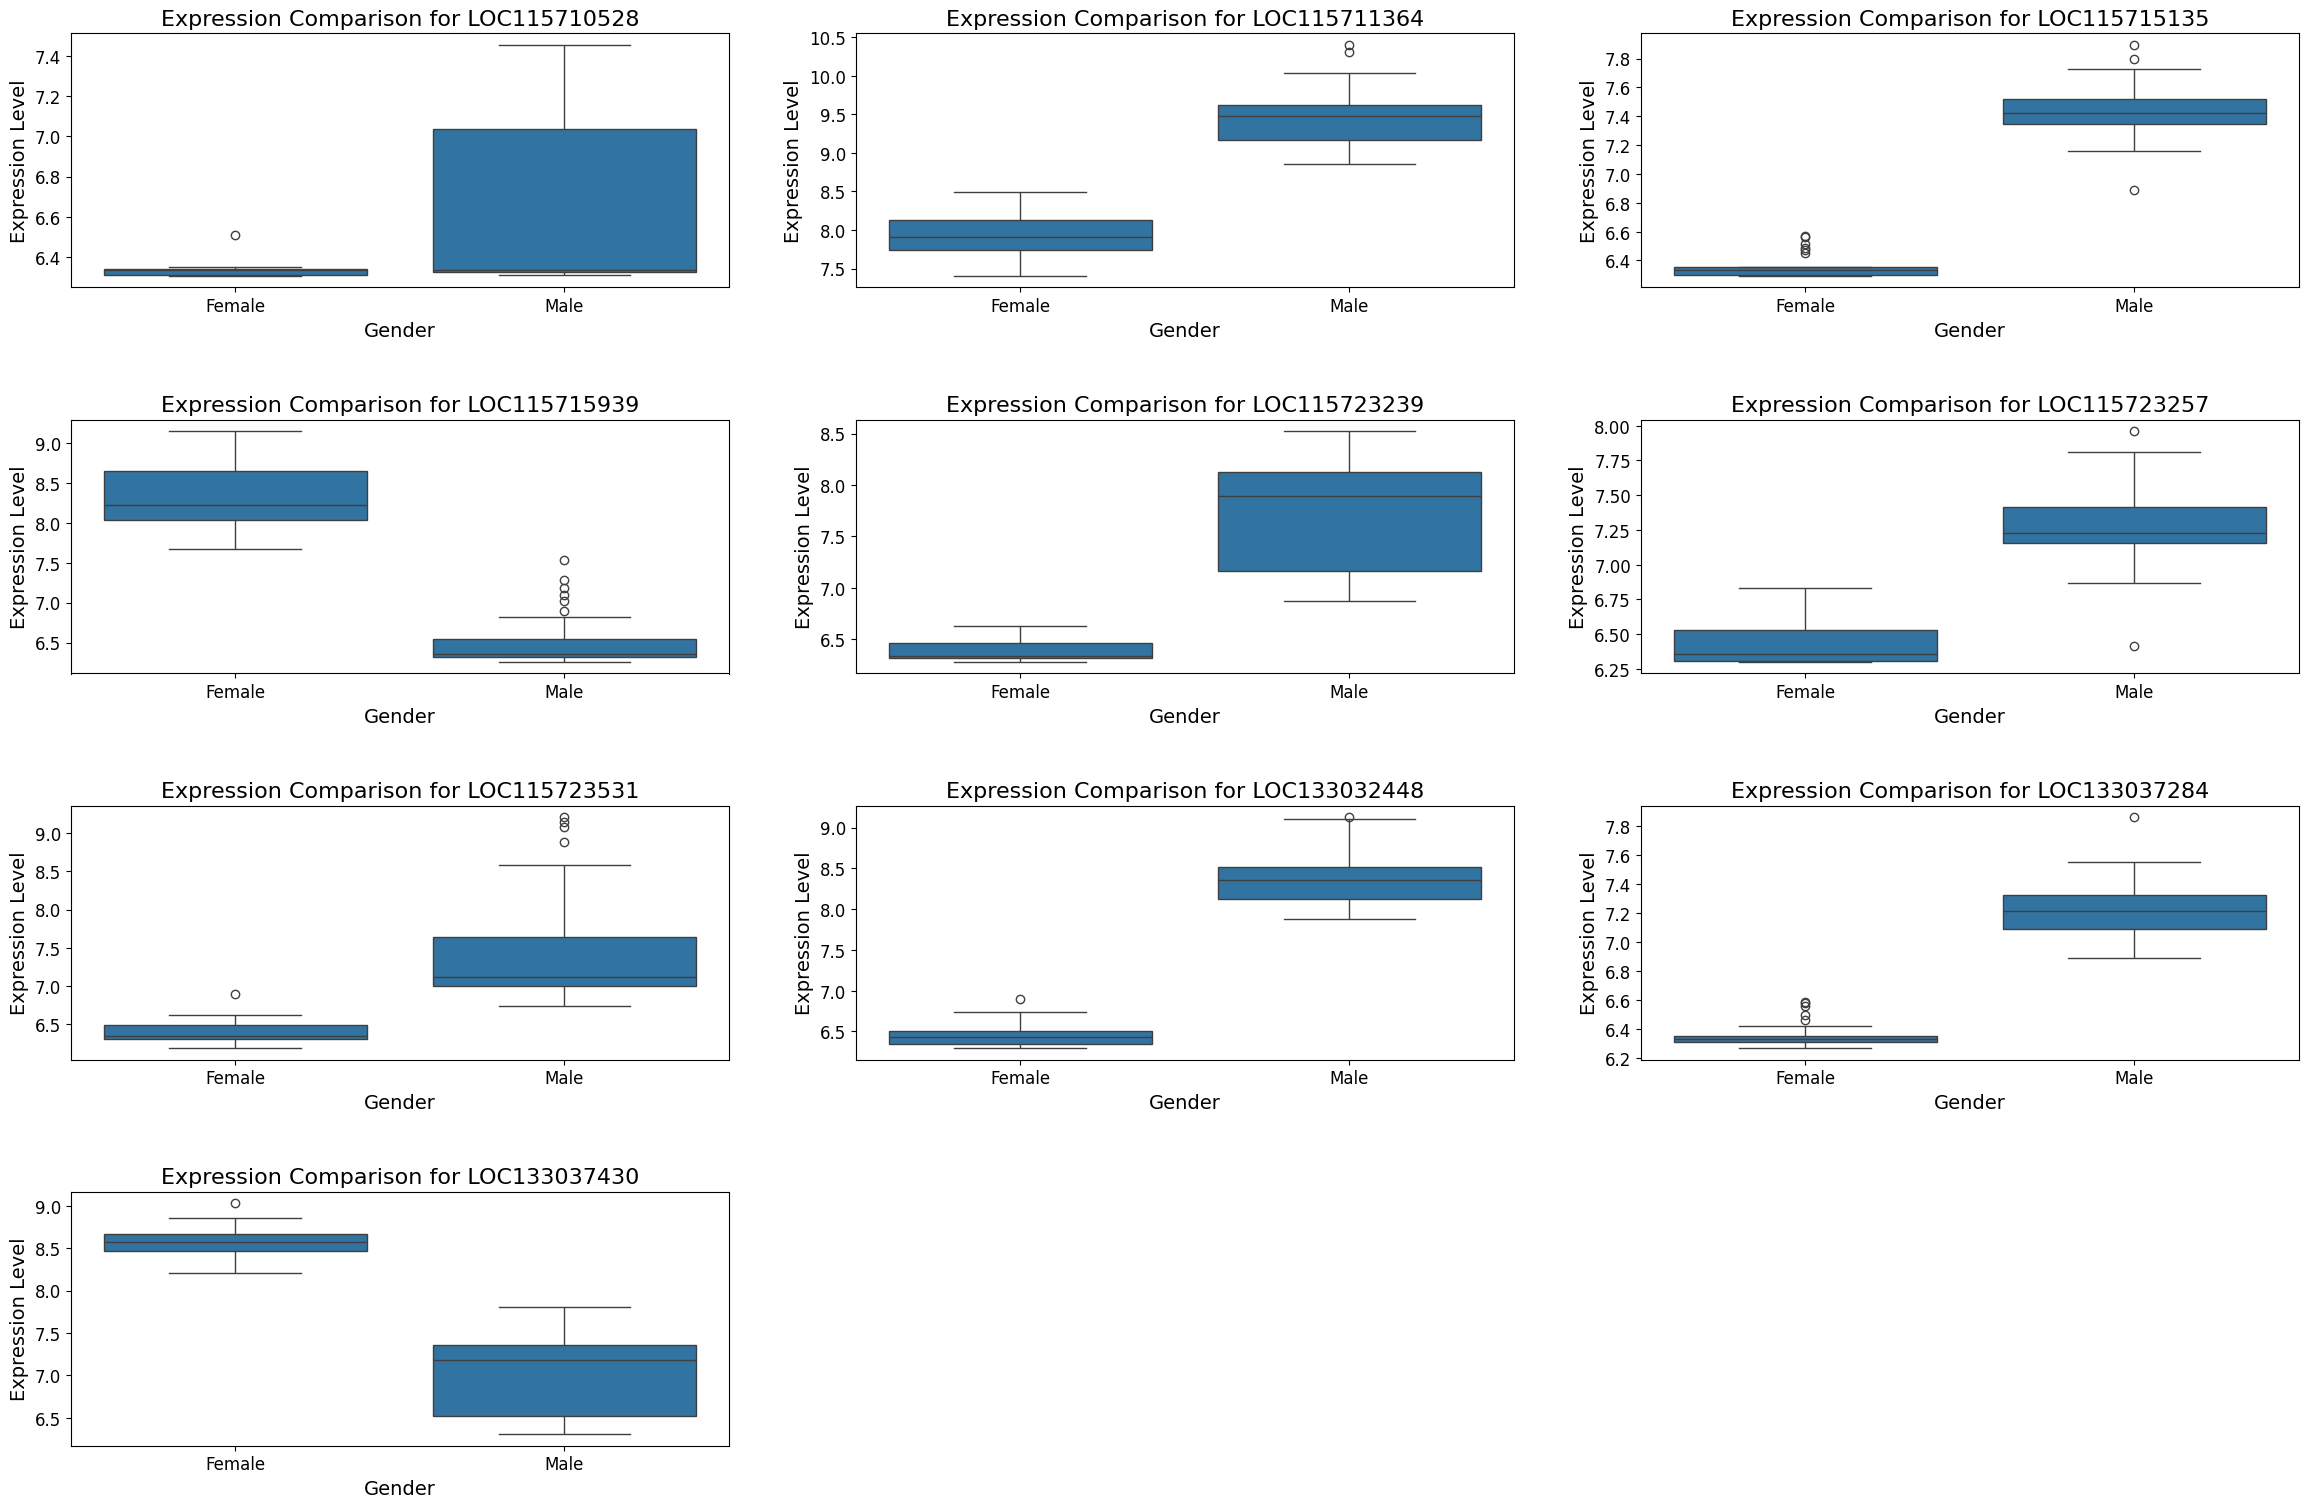

Summary Statistics for LOC115710528:
        count  unique       top  freq
Gender                               
Female   69.0    13.0  6.340436   8.0
Male     69.0    27.0  6.322399   8.0

Summary Statistics for LOC115711364:
        count  unique       top  freq
Gender                               
Female   69.0    69.0  7.545762   1.0
Male     69.0    69.0  9.309641   1.0

Summary Statistics for LOC115715135:
        count  unique       top  freq
Gender                               
Female   69.0    24.0  6.334141   4.0
Male     69.0    69.0  7.582976   1.0

Summary Statistics for LOC115715939:
        count  unique       top  freq
Gender                               
Female   69.0    69.0  8.273268   1.0
Male     69.0    45.0  6.346600   4.0

Summary Statistics for LOC115723239:
        count  unique       top  freq
Gender                               
Female   69.0    39.0  6.331678   4.0
Male     69.0    69.0  8.143808   1.0

Summary Statistics for LOC115723257:
        count

In [31]:
# Assuming `y` contains gender information (e.g., 0 = Male, 1 = Female)
# Replace `y` with the appropriate variable if top_features_indices's named differently
gender_labels = y  # Update this if the gender labels are stored in a different variable

# Extract names of selected genes based on saved indices in the variable 'top_features_indices'
MI_f_names = [feature_names[i] for i in top_features_indices]

# Create a DataFrame with the selected gene data for analysis and visualization
selected_data = pd.DataFrame(X[:, top_features_indices], columns=MI_f_names)

# Add gender labels to the DataFrame
selected_data['Gender'] = gender_labels  # Make sure this aligns with your actual gender label variable

import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a list to store summary statistics
summary_stats = {}

# Set the figure size for better visibility
plt.figure(figsize=(24, 16))  # Adjust size as needed

# Define the number of columns for subplots
n_cols = 3  # Adjust based on the number of genes
n_rows = (len(MI_f_names) + n_cols - 1) // n_cols  # Calculate number of rows needed

for i, gene in enumerate(MI_f_names):
    plt.subplot(n_rows, n_cols, i + 1)  # Create a subplot for each gene
    sns.boxplot(x='Gender', y=gene, data=selected_data)
    plt.title(f'Expression Comparison for {gene}', fontsize=16)  # Increase title font size
    plt.xlabel('Gender', fontsize=14)  # Increase x-label font size
    plt.ylabel('Expression Level', fontsize=14)  # Increase y-label font size
    plt.xticks(rotation=0, fontsize=12)  # Set x-axis labels to horizontal with larger font size
    plt.yticks(fontsize=12)  # Increase y-axis label font size

    # Calculate summary statistics
    stats = selected_data.groupby('Gender')[gene].describe()
    summary_stats[gene] = stats

# Adjust layout to prevent overlap
plt.tight_layout(pad=4.0)

# Save the complete figure as an image file in multiple formats
plt.savefig('output/combined_expression_comparisonV1.png', bbox_inches='tight')  # Save as PNG
plt.savefig('output/combined_expression_comparisonV1.pdf', bbox_inches='tight')  # Save as PDF
plt.savefig('output/combined_expression_comparisonV1.svg', bbox_inches='tight')  # Save as SVG

plt.show()

# Create a DataFrame from summary statistics for saving
summary_df = pd.concat(summary_stats)

# Save summary statistics to a CSV file
summary_df.to_csv('output/summary_statistics.csv')  # Save as CSV

# Optionally, save summary statistics to a text file
with open('output/summary_statistics.txt', 'w') as f:
    f.write(summary_df.to_string())  # Save as text file

# Print summary statistics to the console
for gene, stats in summary_stats.items():
    print(f'Summary Statistics for {gene}:\n{stats}\n')


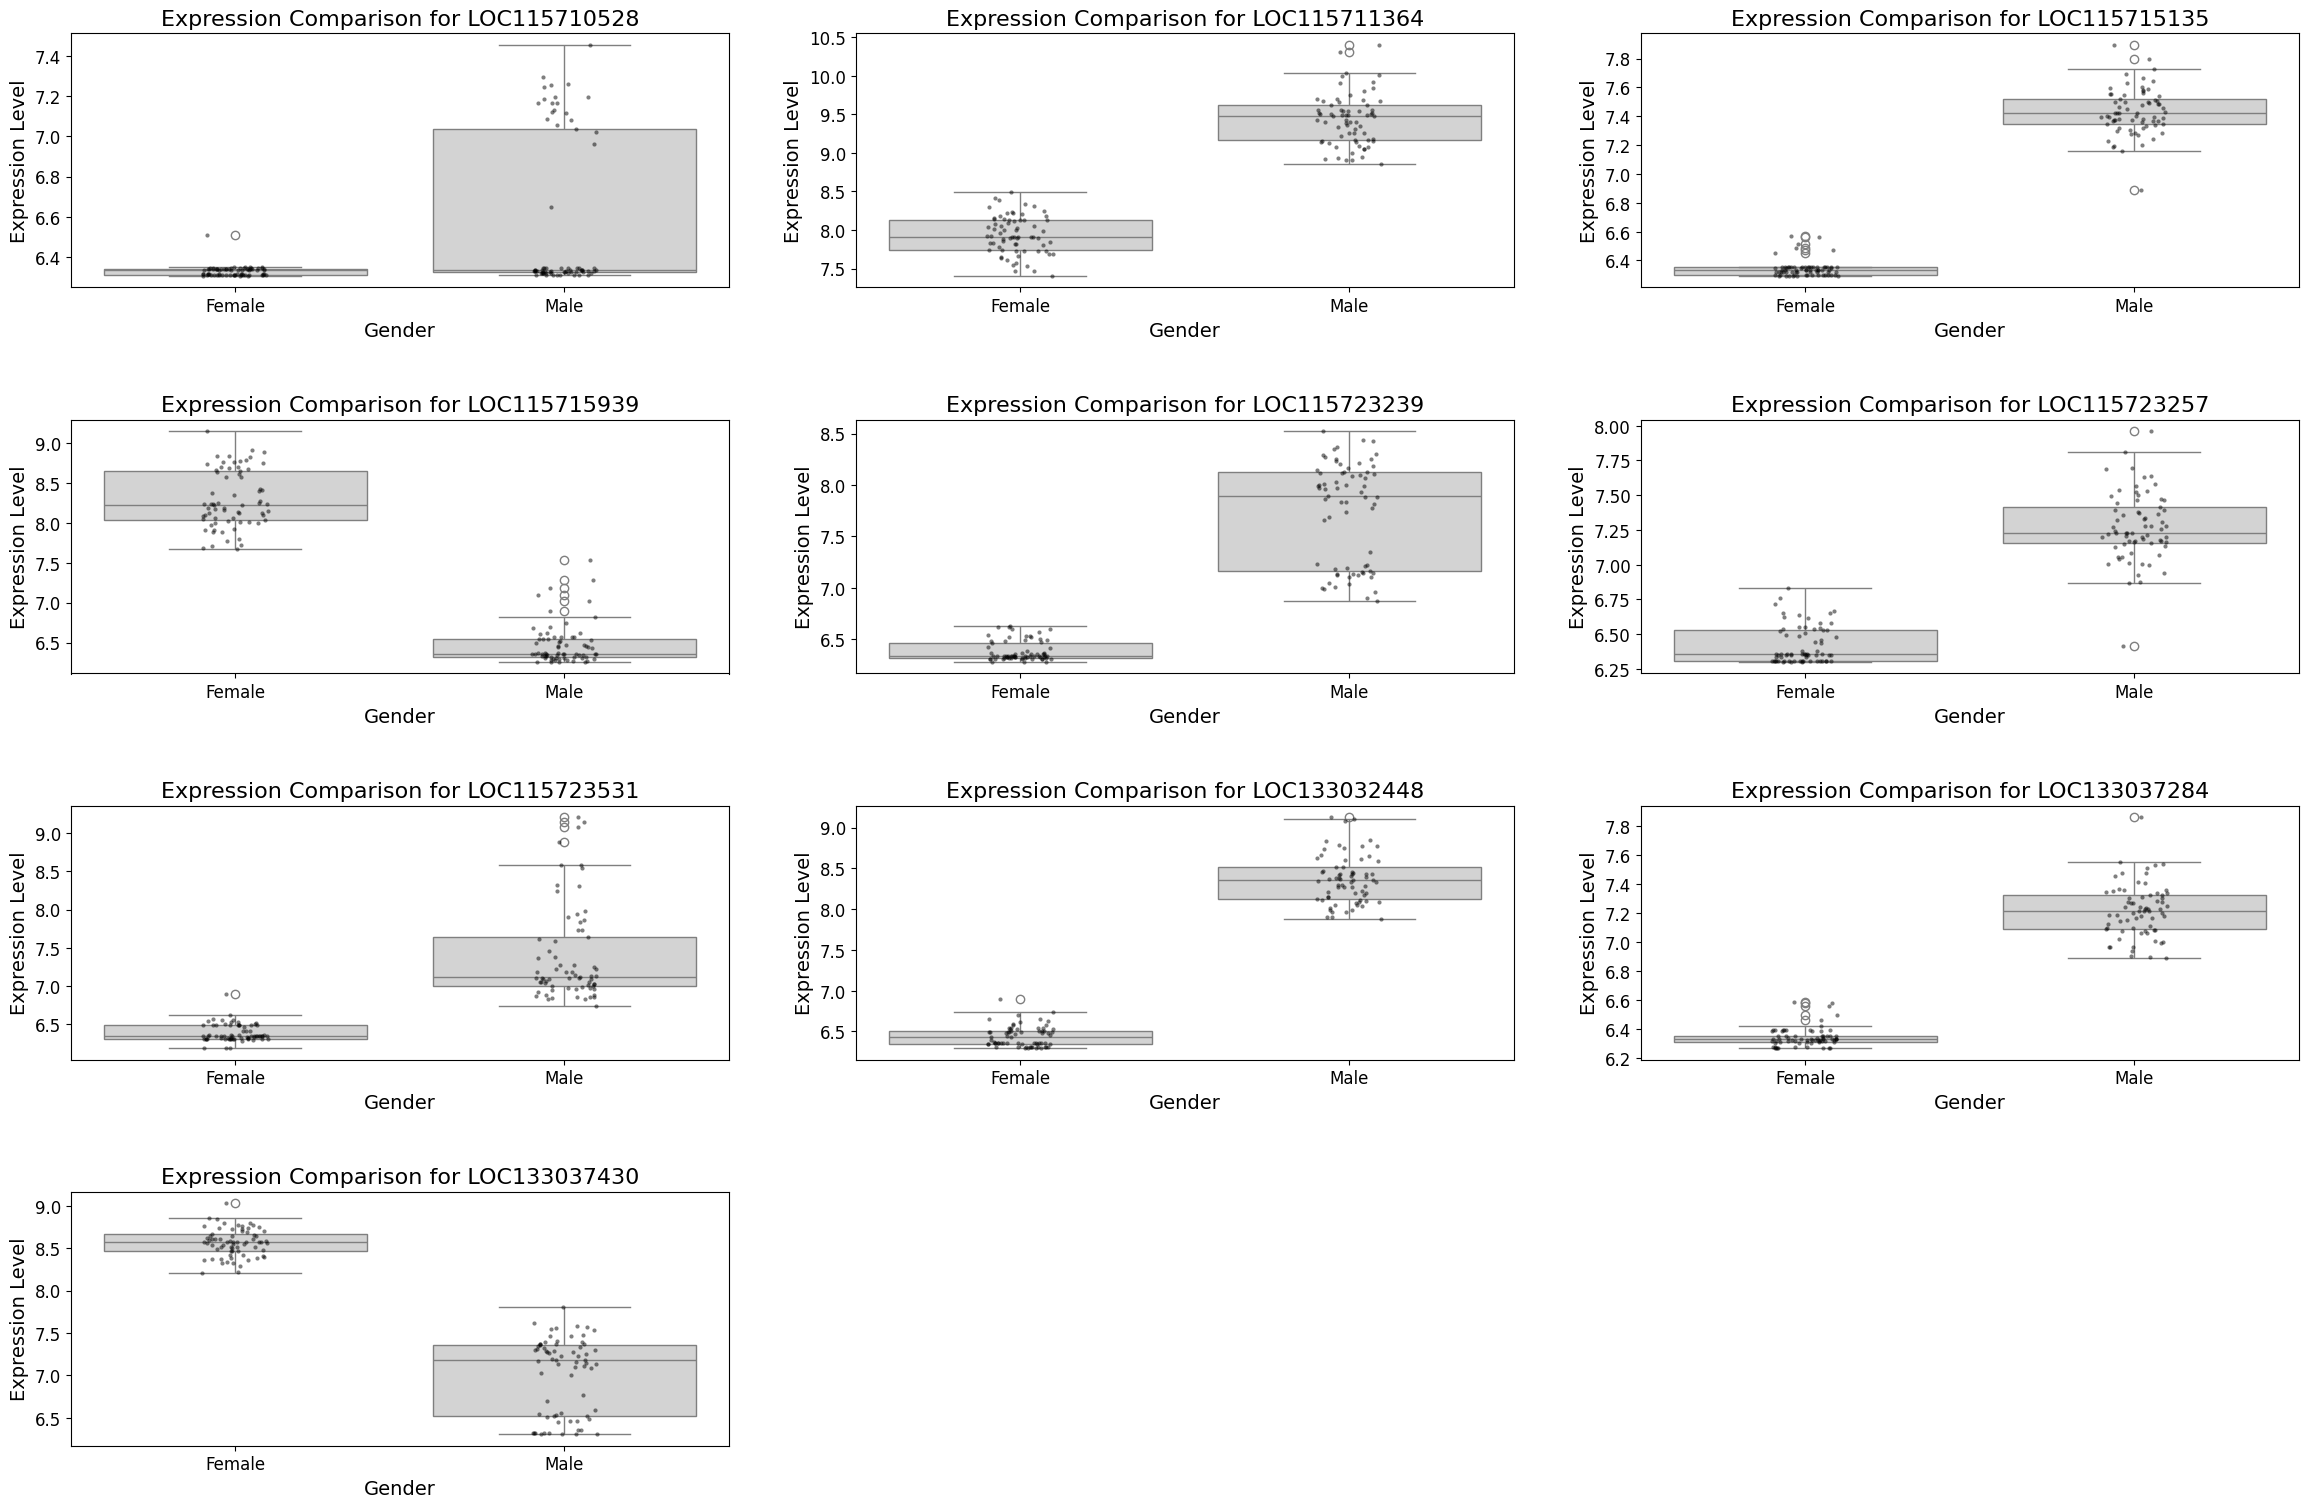

In [32]:
# Set up the figure size for the visualization, making it large enough for clarity.
plt.figure(figsize=(24, 16))  # Adjust the figure size as needed to accommodate all subplots.

# Iterate through the list of selected gene names to create individual boxplots.
for i, gene in enumerate(MI_f_names):
    # Create a subplot for each gene, specifying the grid layout using the row and column counts.
    plt.subplot(n_rows, n_cols, i + 1)  # 'n_rows' and 'n_cols' should be defined based on the number of genes.

    # Generate a boxplot to compare gene expression levels across genders.
    sns.boxplot(x='Gender', y=gene, data=selected_data, color='lightgray')
    
    # Overlay a strip plot to show individual data points, enhancing the visualization.
    # The strip plot adds granularity to the data representation, allowing for better insight into distribution.
    sns.stripplot(x='Gender', y=gene, data=selected_data, color='black', alpha=0.5, size=3)

    # Set the title for each subplot to indicate the gene being analyzed.
    plt.title(f'Expression Comparison for {gene}', fontsize=16)
    
    # Label the x-axis for gender categories.
    plt.xlabel('Gender', fontsize=14)
    
    # Label the y-axis to indicate the measurement of gene expression levels.
    plt.ylabel('Expression Level', fontsize=14)
    
    # Adjust the x-tick labels for better readability.
    plt.xticks(rotation=0, fontsize=12)
    
    # Set the y-tick labels with a specified font size.
    plt.yticks(fontsize=12)

# Optimize the layout to ensure that the subplots are well spaced and not overlapping.
plt.tight_layout(pad=4.0)

# Save the complete figure as an image file
plt.savefig('output/combined_expression_comparisonV2.png', bbox_inches='tight')  # Save the full figure

# Display the complete set of boxplots.
plt.show()


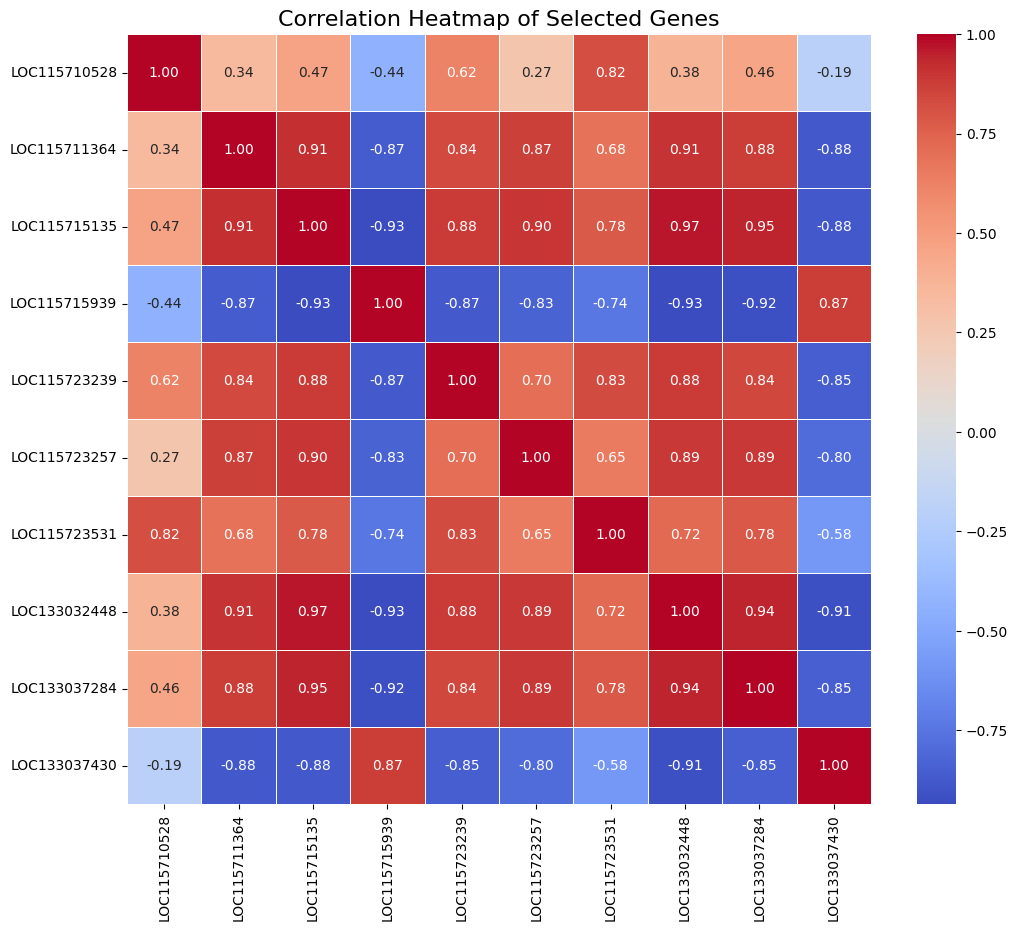

In [33]:
# Calculate the correlation matrix for the selected gene expression data
correlation_matrix = selected_data[MI_f_names].corr()

# Set the size of the figure for the heatmap
plt.figure(figsize=(12, 10))

# Create a heatmap to visualize the correlations between selected genes
# - annot=True: Displays the correlation coefficients on the heatmap
# - cmap='coolwarm': Sets the color palette for the heatmap
# - fmt=".2f": Formats the annotation text to two decimal places
# - linewidths=.5: Adds lines between the cells for better separation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Set the title of the heatmap for context
plt.title('Correlation Heatmap of Selected Genes', fontsize=16)

# Save the complete figure as image files in two formats
plt.savefig('output/Correlation_Heatmap.png', bbox_inches='tight')  # Save as PNG
plt.savefig('output/Correlation_Heatmap.pdf', bbox_inches='tight')  # Save as PDF

# Display the heatmap
plt.show()

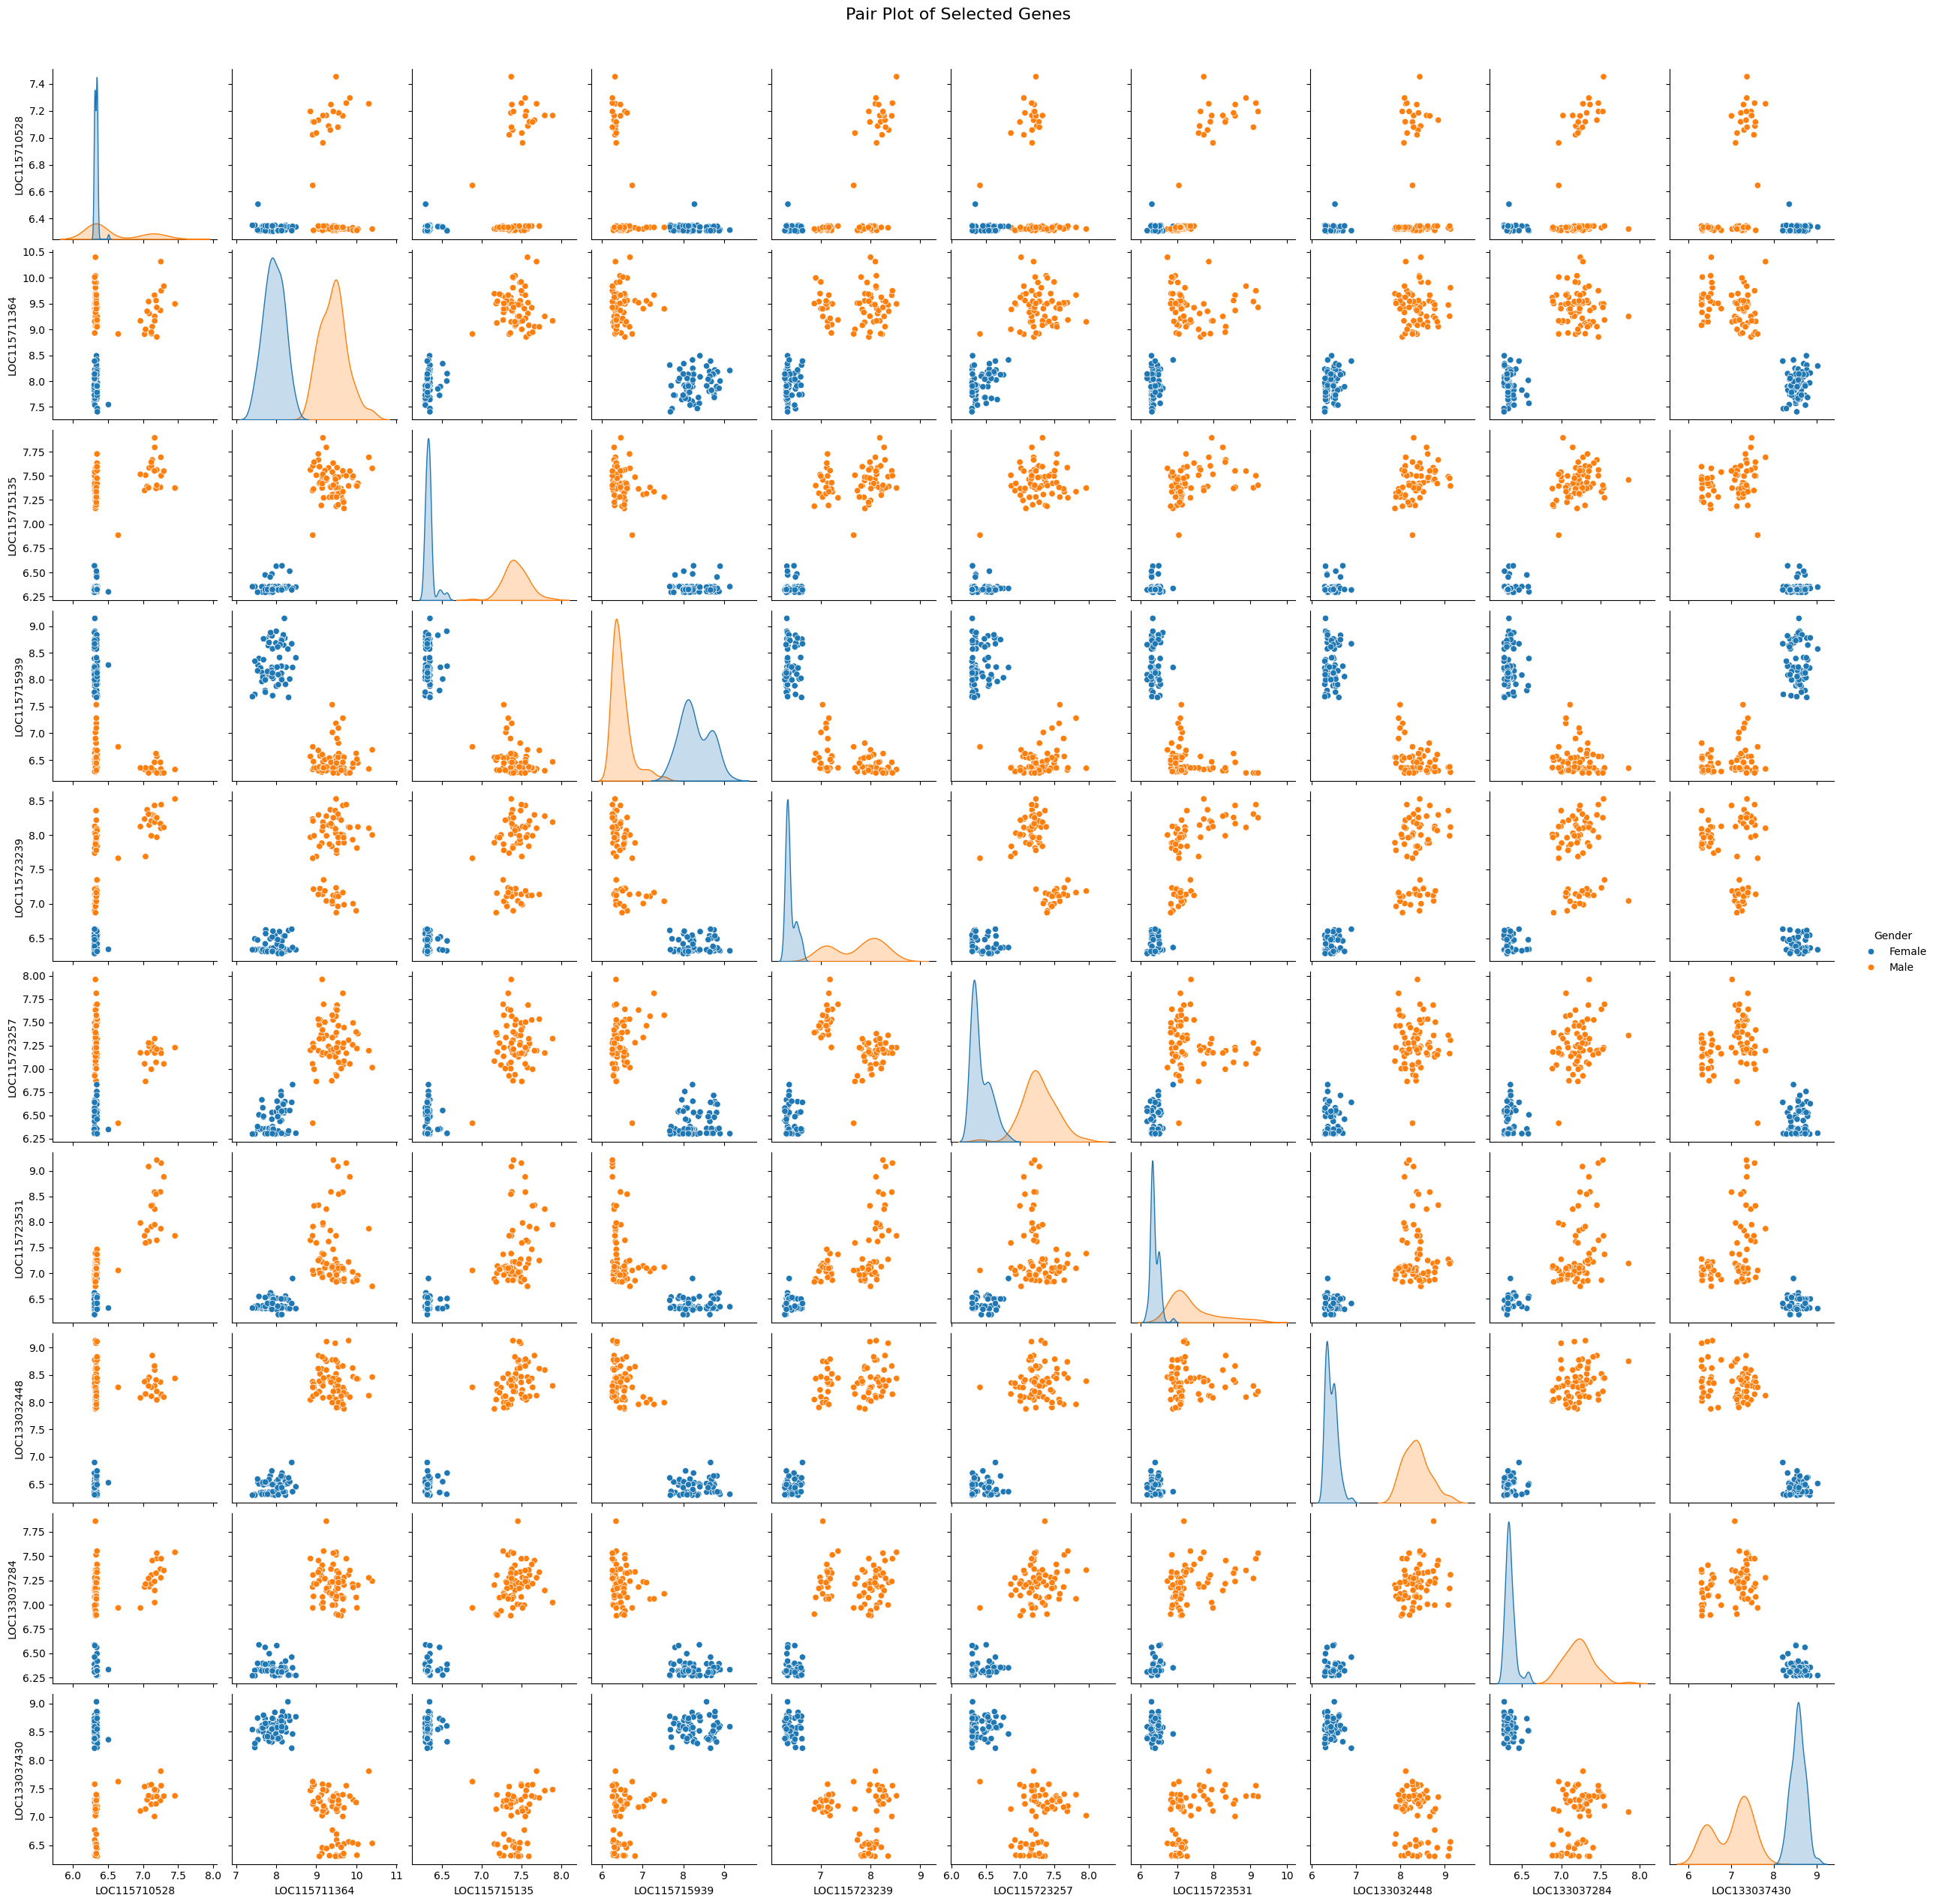

In [34]:
# Create a pair plot to visualize the relationships between selected genes
# - hue='Gender': Color code the points by gender for easy differentiation
# - vars=MI_f_names: Specify which variables (genes) to include in the pair plot
sns.pairplot(selected_data, hue='Gender', vars=MI_f_names)

# Set the title of the pair plot for context
plt.suptitle('Pair Plot of Selected Genes', fontsize=16, y=1.02)  # Adjust y for better positioning of the title

# Save the pair plot as PNG
plt.savefig('output/pair_plot_selected_genes.png', bbox_inches='tight')  # Save as PNG
# Save the pair plot as PDF
plt.savefig('output/pair_plot_selected_genes.pdf', bbox_inches='tight')  # Save as PDF

# Display the pair plot
plt.show()